<h1> Clusterization with y1 + GBR </h1>

In [60]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import numpy as np

# read datasets
train_df = pd.read_csv('data/train3.csv')
test_df = pd.read_csv('data/test3.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test = scaler.transform(X_test)

# prepare dataset from training kmeans
X_train_y3 = np.concatenate((X_train, train_df[y3_name].values.reshape(-1, 1)), axis=1)
scaler_y3 = MaxAbsScaler()
scaler_y3.fit(X_train_y3)
X_train_y3 = scaler_y3.transform(X_train_y3)

<h1> Pick optimal number of clusters (Elbow method) </h1>


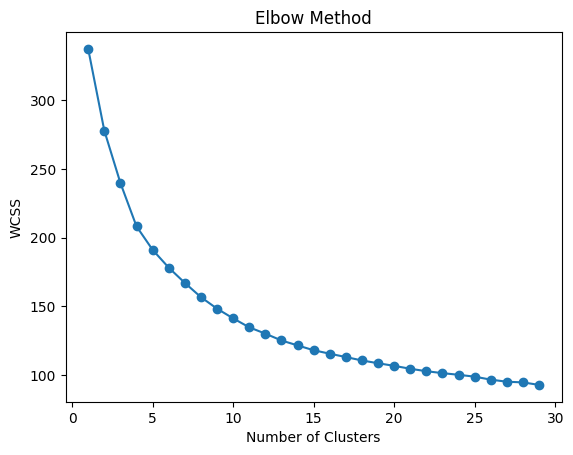

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 30)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_y3)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

<h1> Train kmeans with y3 </h1>

In [61]:
from sklearn.cluster import KMeans

clusters_num = 4
kmeans = KMeans(n_clusters=clusters_num, random_state=42, n_init=10)
kmeans.fit(X_train_y3)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [62]:
import numpy as np
# transforms X into clustered dataset with. k - number of clusters in the range [0, k-1]
def transform_to_clustered_dataset_train(X: np.ndarray, Xy: pd.DataFrame, cluster_predictor, k: int):
    clusters = cluster_predictor.predict(Xy)
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res

def transform_to_clustered_dataset_test(X: np.ndarray, kmeans_model: KMeans, k: int):
    centers = kmeans_model.cluster_centers_[:, :-1]
    clusters = []
    for row in X:
        min_dist = np.Infinity
        cluster = -1
        for i in range(k):
            cur_dist = np.linalg.norm(row - centers[i])
            if cur_dist < min_dist:
                min_dist = cur_dist
                cluster = i
        if cluster == -1:
            raise "Error"
        clusters.append(cluster)
        
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res
            

In [63]:
X_train_clustered = transform_to_clustered_dataset_train(X_train, X_train_y3, kmeans, clusters_num)
X_test_clustered = transform_to_clustered_dataset_test(X_test, kmeans, clusters_num)

In [64]:
X_train_clustered

array([[0.70547832, 0.65629322, 0.55758513, ..., 0.        , 0.        ,
        0.        ],
       [0.6810734 , 0.63313331, 0.43328938, ..., 1.        , 0.        ,
        0.        ],
       [0.90403654, 0.62404112, 0.59067268, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71291621, 0.61862066, 0.49205034, ..., 0.        , 1.        ,
        0.        ],
       [0.68640678, 0.68628034, 0.65645443, ..., 0.        , 0.        ,
        0.        ],
       [0.71849932, 0.63626647, 0.50101859, ..., 0.        , 0.        ,
        1.        ]])

In [65]:
X_test_clustered

array([[0.70059243, 0.58698389, 0.37431062, ..., 0.        , 0.        ,
        0.        ],
       [0.71430125, 0.59126419, 0.38108912, ..., 0.        , 0.        ,
        1.        ],
       [0.71721318, 0.59538773, 0.5399463 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.67157635, 0.60460517, 0.3985426 , ..., 0.        , 1.        ,
        0.        ],
       [0.75211235, 0.5974011 , 0.49576465, ..., 0.        , 0.        ,
        1.        ],
       [0.72167066, 0.6332595 , 0.49694649, ..., 0.        , 0.        ,
        1.        ]])

<h1> GBR with arbitrary hyperparameters </h1>

In [34]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=48, learning_rate=0.096952, max_depth=6, random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              989374501557831.5000000000
Root Mean Squared Error (RMSE):        31454324.0518347733
Mean Absolute Error (MAE):             16344252.2442255169
R-squared (R²):                        0.6074637346
Mean Absolute Percentage Error (MAPE): 0.1729346794
Max Error (ME):                        227502026.6070165038
Median Absolute Error (MedAE):         6439256.3760030791
------ train metrics ------
Mean Squared Error (MSE):              59434289977257.9843750000
Root Mean Squared Error (RMSE):        7709363.7855051300
Mean Absolute Error (MAE):             5189125.3275211481
R-squared (R²):                        0.9779540430
Mean Absolute Percentage Error (MAPE): 0.0718563822
Max Error (ME):                        51963129.0358241796
Median Absolute Error (MedAE):         3365017.5084366091


<h1> Optimize Gradient boost parameters using Differential evolution</h1>

In [35]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.optimize import differential_evolution

# define objective function
def objective_function(params, train_X, train_y, test_X, test_y):
    regressor = GradientBoostingRegressor(n_estimators=int(params[0]), learning_rate=params[1], max_depth=int(params[2]), random_state=42)
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [36]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(2, 300), (0.0001, 0.5), (2, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=10,
                                          args=(X_train_clustered, train_y3, X_test_clustered, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.683602
differential_evolution step 2: f(x)= -0.684766
differential_evolution step 3: f(x)= -0.684766
differential_evolution step 4: f(x)= -0.684804
differential_evolution step 5: f(x)= -0.684804
differential_evolution step 6: f(x)= -0.686868
differential_evolution step 7: f(x)= -0.686868
differential_evolution step 8: f(x)= -0.691522
differential_evolution step 9: f(x)= -0.691522
differential_evolution step 10: f(x)= -0.691522
Polishing solution with 'L-BFGS-B'
 message: Maximum number of iterations has been exceeded.
 success: False
     fun: -0.6915218900878706
       x: [ 7.130e+01  3.443e-01  2.585e+00]
     nit: 10
    nfev: 739


In [37]:
optimization_res.x

array([71.29621208,  0.34433561,  2.58503604])

In [66]:
from metrics import print_metrics
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=int(71), learning_rate=0.344336, max_depth=int(2), random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_clustered, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, gb_regressor.predict(X_test_clustered))

print("------ train metrics ------")
print_metrics(train_y3, gb_regressor.predict(X_train_clustered))

------ test metrics ------
Mean Squared Error (MSE):              777508774245377.7500000000
Root Mean Squared Error (RMSE):        27883844.3232883103
Mean Absolute Error (MAE):             15605351.4423297662
R-squared (R²):                        0.6915218756
Mean Absolute Percentage Error (MAPE): 0.1845378868
Max Error (ME):                        230562531.4466585517
Median Absolute Error (MedAE):         7909892.4563062191
------ train metrics ------
Mean Squared Error (MSE):              333443169800846.8125000000
Root Mean Squared Error (RMSE):        18260426.3313003406
Mean Absolute Error (MAE):             11410323.3540402222
R-squared (R²):                        0.8763159485
Mean Absolute Percentage Error (MAPE): 0.1462820220
Max Error (ME):                        187119441.7855732739
Median Absolute Error (MedAE):         7580222.9778496101


<h1> Add ridge </h1>

<h2> Create new dataset </h2>

In [67]:
X_train_clustered_GBR = np.concatenate((X_train_clustered, gb_regressor.predict(X_train_clustered).reshape(-1, 1)), axis=1)
X_test_clustered_GBR = np.concatenate((X_test_clustered, gb_regressor.predict(X_test_clustered).reshape(-1, 1)), axis=1)

In [68]:
X_train_clustered_GBR

array([[7.05478325e-01, 6.56293220e-01, 5.57585131e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.28881352e+07],
       [6.81073399e-01, 6.33133310e-01, 4.33289384e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.68243193e+07],
       [9.04036543e-01, 6.24041121e-01, 5.90672680e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.96184452e+07],
       ...,
       [7.12916214e-01, 6.18620656e-01, 4.92050341e-01, ...,
        1.00000000e+00, 0.00000000e+00, 5.60780058e+07],
       [6.86406784e-01, 6.86280345e-01, 6.56454429e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.41580989e+07],
       [7.18499320e-01, 6.36266471e-01, 5.01018591e-01, ...,
        0.00000000e+00, 1.00000000e+00, 6.35564995e+07]])

In [69]:
X_test_clustered_GBR

array([[7.00592435e-01, 5.86983890e-01, 3.74310622e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.38713405e+07],
       [7.14301245e-01, 5.91264186e-01, 3.81089121e-01, ...,
        0.00000000e+00, 1.00000000e+00, 8.98018828e+07],
       [7.17213179e-01, 5.95387731e-01, 5.39946302e-01, ...,
        0.00000000e+00, 0.00000000e+00, 4.33569070e+07],
       ...,
       [6.71576353e-01, 6.04605175e-01, 3.98542605e-01, ...,
        1.00000000e+00, 0.00000000e+00, 4.15177418e+07],
       [7.52112348e-01, 5.97401097e-01, 4.95764647e-01, ...,
        0.00000000e+00, 1.00000000e+00, 4.73062158e+07],
       [7.21670656e-01, 6.33259498e-01, 4.96946489e-01, ...,
        0.00000000e+00, 1.00000000e+00, 7.28977691e+07]])

<h2> Scale features </h2>

In [70]:
# scale features
scaler_GBR = MaxAbsScaler()
scaler_GBR.fit(X_train_clustered_GBR)
X_train_clustered_GBR = scaler_GBR.transform(X_train_clustered_GBR)
X_test_clustered_GBR = scaler_GBR.transform(X_test_clustered_GBR)

In [71]:
X_train_clustered_GBR.shape

(1290, 13)

In [72]:
X_test_clustered_GBR

array([[0.70059243, 0.58698389, 0.37431062, ..., 0.        , 0.        ,
        0.06047902],
       [0.71430125, 0.59126419, 0.38108912, ..., 0.        , 1.        ,
        0.22751675],
       [0.71721318, 0.59538773, 0.5399463 , ..., 0.        , 0.        ,
        0.1098465 ],
       ...,
       [0.67157635, 0.60460517, 0.3985426 , ..., 1.        , 0.        ,
        0.1051869 ],
       [0.75211235, 0.5974011 , 0.49576465, ..., 0.        , 1.        ,
        0.11985223],
       [0.72167066, 0.6332595 , 0.49694649, ..., 0.        , 1.        ,
        0.18468948]])

In [54]:
# from sklearn.linear_model import Ridge
# from metrics import print_metrics
# 
# gtm = GTM(numb_of_steps=77)
# Train the model
# gtm.fit(X_train_clustered_GBR, train_y3)
# 
# print("------ test metrics ------")
# print_metrics(test_y3, gtm.predict(X_test_clustered_GBR))
# 
# print("------ train metrics ------")
# print_metrics(train_y3, gtm.predict(X_train_clustered_GBR))

105
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Break, step = 77
--- 1.6012868881225586 seconds ---
------ test metrics ------
Mean Squared Error (MSE):              808639227875518.6250000000
Root Mean Squared Error (RMSE):        28436582.5632321462
Mean Absolute Error (MAE):             16116851.5949902143
R-squared (R²):                        0.67917080

<h1> Optimize alpha parameter of Ridge regression <h1>

In [77]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function_ridge_regression(params, train_X, train_y, test_X, test_y):
    regressor = Ridge(alpha=params[0])
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [23]:
optimization_res = differential_evolution(func=objective_function_ridge_regression, 
                                          bounds=[(0, 50)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=100,
                                          args=(X_train_clustered_GBR, train_y3, X_test_clustered_GBR, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.712885
differential_evolution step 2: f(x)= -0.71528
differential_evolution step 3: f(x)= -0.71528
differential_evolution step 4: f(x)= -0.71528
differential_evolution step 5: f(x)= -0.71528
differential_evolution step 6: f(x)= -0.71528
differential_evolution step 7: f(x)= -0.7153
differential_evolution step 8: f(x)= -0.7153
differential_evolution step 9: f(x)= -0.7153
differential_evolution step 10: f(x)= -0.7153
differential_evolution step 11: f(x)= -0.7153
Polishing solution with 'L-BFGS-B'
 message: Optimization terminated successfully.
 success: True
     fun: -0.715299716950279
       x: [ 1.147e+00]
     nit: 11
    nfev: 184
     jac: [ 1.319e-05]


In [24]:
optimization_res.x

array([1.14743042])

In [57]:
X_test_clustered_GBR

array([[1.        , 0.70059243, 0.58698389, ..., 0.        , 0.        ,
        0.00365771],
       [1.        , 0.71430125, 0.59126419, ..., 1.        , 0.22751675,
        0.05176387],
       [1.        , 0.71721318, 0.59538773, ..., 0.        , 0.        ,
        0.01206625],
       ...,
       [1.        , 0.67157635, 0.60460517, ..., 0.        , 0.        ,
        0.01106428],
       [1.        , 0.75211235, 0.5974011 , ..., 1.        , 0.11985223,
        0.01436456],
       [1.        , 0.72167066, 0.6332595 , ..., 1.        , 0.18468948,
        0.0341102 ]])

In [73]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_train_clustered_GBR_poly = poly.fit_transform(X_train_clustered_GBR)
X_test_clustered_GBR_poly = poly.fit_transform(X_test_clustered_GBR)

In [75]:
X_test_clustered_GBR_poly

array([[1.        , 0.70059243, 0.58698389, ..., 0.        , 0.        ,
        0.00365771],
       [1.        , 0.71430125, 0.59126419, ..., 1.        , 0.22751675,
        0.05176387],
       [1.        , 0.71721318, 0.59538773, ..., 0.        , 0.        ,
        0.01206625],
       ...,
       [1.        , 0.67157635, 0.60460517, ..., 0.        , 0.        ,
        0.01106428],
       [1.        , 0.75211235, 0.5974011 , ..., 1.        , 0.11985223,
        0.01436456],
       [1.        , 0.72167066, 0.6332595 , ..., 1.        , 0.18468948,
        0.0341102 ]])

In [81]:
from sklearn.linear_model import Ridge
from metrics import print_metrics


# Create a Ridge regression model
ridge_reg = Ridge(alpha=5.239971)  # You can adjust the regularization strength with the alpha parameter

# Train the model
ridge_reg.fit(X_train_clustered_GBR, train_y3)

print("------ test metrics ------")
print_metrics(test_y3, ridge_reg.predict(X_test_clustered_GBR))

print("------ train metrics ------")
print_metrics(train_y3, ridge_reg.predict(X_train_clustered_GBR))

------ test metrics ------
Mean Squared Error (MSE):              822097706903843.2500000000
Root Mean Squared Error (RMSE):        28672246.2828401923
Mean Absolute Error (MAE):             16614777.4388599861
R-squared (R²):                        0.6738311295
Mean Absolute Percentage Error (MAPE): 0.2025358420
Max Error (ME):                        232716827.1800073385
Median Absolute Error (MedAE):         9220682.9619744793
------ train metrics ------
Mean Squared Error (MSE):              495913432362482.8750000000
Root Mean Squared Error (RMSE):        22269113.8656768948
Mean Absolute Error (MAE):             13637705.5437027477
R-squared (R²):                        0.8160508654
Mean Absolute Percentage Error (MAPE): 0.1714013543
Max Error (ME):                        194579425.2892482877
Median Absolute Error (MedAE):         9273054.0894331485


In [59]:
import math
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
class GTM(BaseEstimator, ClassifierMixin):

    def __init__(self, name = "GTM", numb_of_steps = 1000, n_iter = 50, center_of_mass = False):
        self.name = name
        self.numb_of_steps = numb_of_steps
        self.n_iter = n_iter
        self.center_of_mass = center_of_mass
        

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        start_time = time.time()
        
        m = X.shape[1]
        step = 0
        
        if self.numb_of_steps > m:
            print("Number of steps should be lower then features count (" + str(m) +")")
        print(m)
        
        centered_X = X
        centered_y = y
        
        com_x = np.zeros(m)
        com_y = 0 #np.zeros(y.shape[1])
        
        if self.center_of_mass:
            com_x = np.mean(X, axis=0)
            com_y = np.mean(y)
            centered_X = X - com_x
            centered_y = y - com_y
        
        
        self.com_x = com_x
        self.com_y = com_y
           
        self.basic_instances = []
        self.b_instances_x = []
        self.b_instances_y = []
        
    
        while step < m:
            iter = 0
            
            #TODO change
            i = np.argmax(np.sum(centered_X**2, axis=1))
            
            initial_instance = centered_X[i,]
            
            basic_instance = initial_instance
            
            while iter < self.n_iter:
                vector_relations = np.sum(np.multiply(centered_X, basic_instance), axis=1) \
                / np.sum(basic_instance**2)
                basic_instance = np.sum(np.multiply(centered_X, vector_relations[:, np.newaxis]), axis=0) \
                / np.sum(vector_relations**2)
                iter = iter + 1
                
            k1_values = np.sum(np.multiply(centered_X, basic_instance), axis=1) \
            / np.sum(basic_instance**2, axis=0)
            
            k2_values = np.sum(np.multiply(centered_X, basic_instance), axis=1) \
            / math.sqrt(np.sum(basic_instance**2, axis=0))
            
            if step == self.numb_of_steps:
                self.num_steps = step
                print("Break, step = " + str(step))
                break
                
            b_instance_x = np.sum(np.multiply(centered_X, k1_values[:, np.newaxis]), axis=0) \
            / np.sum(k1_values**2, axis=0)
            
    
            b_instance_y = np.sum(np.multiply(centered_y, k1_values), axis=0) \
            / np.sum(k1_values**2, axis=0)
            
    
            centered_X = np.subtract(centered_X, np.multiply(k1_values[:, np.newaxis], b_instance_x))
            centered_y = np.subtract(centered_y, np.multiply(k1_values, b_instance_y))

            
            self.basic_instances.append(basic_instance)
            self.b_instances_x.append(b_instance_x)
            self.b_instances_y.append(b_instance_y)
            
            step = step + 1
            print("Step: " + str(step))
            
        self.num_steps = step
        print("--- %s seconds ---" % (time.time() - start_time))
        
        return self

    def predict(self, X):

        # Check is fit had been called
        #check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        centered_X = X
        
        if self.center_of_mass:
            com_x = self.com_x
            centered_X = X - com_x
        
        k1_values_a = []
        
        for step in range(0, self.num_steps):
            k1_values = np.sum(np.multiply(centered_X, self.basic_instances[step]), axis=1) \
            / np.sum(self.basic_instances[step]**2, axis=0)
            centered_X = np.subtract(centered_X, np.multiply(k1_values[:, np.newaxis], self.b_instances_x[step]))
            k1_values_a.append(k1_values)
        
        y = np.zeros(X.shape[0])
        
        for step in reversed(range(0, self.num_steps)):
            y = np.multiply(k1_values_a[step], self.b_instances_y[step]) + y
            
        y = y + self.com_y
        
        return y

In [78]:
optimization_res = differential_evolution(func=objective_function_ridge_regression, 
                                          bounds=[(0, 50)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.00001,
                                          atol=0.00001,
                                          maxiter=100,
                                          args=(X_train_clustered_GBR_poly, train_y3, X_test_clustered_GBR_poly, test_y3))
print(optimization_res)

differential_evolution step 1: f(x)= -0.695663
differential_evolution step 2: f(x)= -0.695761
differential_evolution step 3: f(x)= -0.695761
differential_evolution step 4: f(x)= -0.695761
differential_evolution step 5: f(x)= -0.695761
differential_evolution step 6: f(x)= -0.695761
differential_evolution step 7: f(x)= -0.695761
differential_evolution step 8: f(x)= -0.695761
Polishing solution with 'L-BFGS-B'
 message: Optimization terminated successfully.
 success: True
     fun: -0.6957610077223935
       x: [ 5.240e+00]
     nit: 8
    nfev: 139
     jac: [-1.008e-05]


In [79]:
optimization_res.x

array([5.23997059])